# VAE using the reparametrization trick

In [2]:
_DEBUG_          = False   # general flag for debug mode
_D_ZERO_DATA_    = True    # basically a debug mode in order to overfit the model on the most simple data
_D_NO_COMPRESSION_ = True  # if true, the latent_space will be the same dimension as the input. basically the model needs to learn the identity function
_USE_TIME_SERIES_  = True  # TODO make the time series also work on 2d data 
_USE_2D_DATA_ = True
_TIME_SERIES_LENGTH_ = 10
_BATCH_SIZE_ = 100

In [3]:
# to generate gifs
#!pip install imageio

## Import TensorFlow and enable Eager execution

In [4]:
# Import TensorFlow >= 1.9 and enable eager execution
import tensorflow as tf
tfe = tf.contrib.eager
tf.enable_eager_execution()

tfk = tf.keras
tfkl = tf.keras.layers


import warnings
import os
import time
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import imageio
from IPython import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE

from drosoph_vae.helpers.misc import extract_args, chunks, foldl
from drosoph_vae.helpers.jupyter import fix_layout, display_video
from drosoph_vae.settings import config, skeleton
from drosoph_vae.helpers import video, plots, misc, jupyter
from drosoph_vae import preprocessing
from drosoph_vae.helpers.logging import enable_logging
from drosoph_vae.helpers.tensorflow import _TF_DEFAULT_SESSION_CONFIG_

W0511 17:41:02.134924 140184169273152 lazy_loader.py:50] 
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0511 17:41:02.279418 140184169273152 deprecation_wrapper.py:119] From /home/samuel/SOM-VAE/drosoph_vae/helpers/tensorflow.py:4: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [5]:
jupyter.fix_layout()

In [6]:
from drosoph_vae.helpers.tensorflow import _TF_DEFAULT_SESSION_CONFIG_
sess = tf.InteractiveSession(config=_TF_DEFAULT_SESSION_CONFIG_)
tf.keras.backend.set_session(sess)

## Loading of 2d data

In [7]:
!ls $config.__EXPERIMENT_ROOT__

180918_MDN_CsCh  180919_MDN_CsCh  180920_MDN_CsCh  180921_MDN_PR
180918_MDN_PR	 180919_MDN_PR	  180920_MDN_PR    181220_Rpr_R57C10_GC6s_tdTom
180919_aDN_CsCh  180920_aDN_CsCh  180921_aDN_CsCh
180919_aDN_PR	 180920_aDN_PR	  180921_aDN_PR


In [8]:
from functional import seq
from pathlib import Path
from functools import reduce

In [9]:
from drosoph_vae.settings import data as SD
from importlib import reload
reload(SD)

<module 'drosoph_vae.settings.data' from '/home/samuel/SOM-VAE/drosoph_vae/settings/data.py'>

In [10]:
if False:
    def experiments_from_root(root=config.__EXPERIMENT_ROOT__):
        return seq(Path(root).iterdir()).flat_map(lambda p: (c for c in p.iterdir() if c.is_dir()))\
                                        .flat_map(lambda p: (c for c in p.iterdir() if c.is_dir()))\
                                        .map(lambda p: reduce(lambda acc, el: ([*acc[0], acc[1].stem], acc[1].parent), range(3), ([], p)))\
                                        .map(lambda pair: list(reversed(pair[0])))\
                                        .map(lambda ls: SD.Experiment._make([*ls, SD._key_from_list_(ls)]))\
                                        .to_list()

    all_experiments = experiments_from_root()
    print(len(all_experiments))

    pos_data = preprocessing.get_data_and_normalization(all_experiments, per_experiment=True)

    norm_pos_data, norm_pos_data_params = zip(*[preprocessing.normalize(p) for p in pos_data])
    experiment_lengths = [len(p) for p in norm_pos_data] # for applying the right normalization factors
    norm_pos_data = np.vstack(norm_pos_data)

    print(f"in total we have {len(all_experiments)} experiments, but only {len(experiment_lengths)} are usable right now")

    norm_pos_data_embedded = TSNE(n_components=2, random_state=42).fit_transform(norm_pos_data[:, :, :2].reshape(norm_pos_data.shape[0], -1))

    #_cs = sns.color_palette(n_colors=len(seen_labels))
    #
    #fig = plt.figure(figsize=(10, 10))
    #_all_frames_ = pd.concat((training_frames, testing_frames))
    #
    #behaviour_colours = dict(zip(seen_labels, _cs))
    #
    #for l, c in behaviour_colours.items():
    #    _d = X_embedded[_all_frames_['label'] == l]
    #    # c=[c] since matplotlib asks for it
    #    plt.scatter(_d[:, 0], _d[:,1], c=[c], label=l.name, marker='.')
    #    
    #plt.legend()
    #plt.title('simple t-SNE on latent space')
    #fig.savefig(f"../neural_clustering_data/figures/{drosoph_vae_config['ex_name']}_tsne.png")

    _cs = sns.color_palette(n_colors=len(experiment_lengths))


    used_until = 0
    for i, l in enumerate(experiment_lengths):
        plt.scatter(norm_pos_data_embedded[used_until:used_until+l, 0], norm_pos_data_embedded[used_until:used_until+l, 1], c=[_cs[i]])
        used_until += l

In [11]:
from drosoph_vae import settings
from drosoph_vae import preprocessing

joint_positions, normalisation_factors = preprocessing.get_data_and_normalization(settings.data.EXPERIMENTS)

frames_idx_with_labels = preprocessing.get_frames_with_idx_and_labels(settings.data.LABELLED_DATA)[:len(joint_positions)]

#frames_of_interest = frames_idx_with_labels.label.isin([settings.data._BehaviorLabel_.GROOM_ANT, settings.data._BehaviorLabel_.WALK_FORW, settings.data._BehaviorLabel_.REST])
frames_of_interest = ~frames_idx_with_labels.label.isin([settings.data._BehaviorLabel_.REST])

joint_positions = joint_positions[frames_of_interest]
frames_idx_with_labels = frames_idx_with_labels[frames_of_interest]

W0511 17:41:03.835482 140184169273152 preprocessing.py:68] this works only for the first legs!
W0511 17:41:04.228752 140184169273152 preprocessing.py:68] this works only for the first legs!
W0511 17:41:04.598598 140184169273152 preprocessing.py:68] this works only for the first legs!
W0511 17:41:05.275677 140184169273152 preprocessing.py:68] this works only for the first legs!
W0511 17:41:05.632328 140184169273152 preprocessing.py:68] this works only for the first legs!


# preprocessing

In [12]:
def to_time_series(data, sequence_length):
    for i in range(len(data)):
        if i + sequence_length <= len(data):
            yield data[i:i+sequence_length]

In [13]:
#scaler = StandardScaler()
scaler = MinMaxScaler()

# flatten the data
if _USE_TIME_SERIES_:
    # TODO the scaling should be learned on the training data only
    warnings.warn('this is not proper, fix the standardisation here')
    reshaped_joint_position = scaler.fit_transform(joint_positions[:,:,:2].reshape(joint_positions.shape[0], -1).astype(np.float32))
    reshaped_joint_position = np.array(list(to_time_series(reshaped_joint_position, sequence_length=_TIME_SERIES_LENGTH_)))
else:
    reshaped_joint_position = joint_positions[:,:,:2].reshape(joint_positions.shape[0], -1).astype(np.float32)

if _DEBUG_ and _D_ZERO_DATA_:
    reshaped_joint_position = scaler.fit_transform(np.zeros_like(reshaped_joint_position))

# scaling the data to be in [0, 1]
# this is due to the sigmoid activation function in the reconstruction
#scaler = MinMaxScaler()

print(f"total number of input data:{reshaped_joint_position.shape}")

n_of_data_points = int(reshaped_joint_position.shape[0] * 0.7)

if _USE_TIME_SERIES_:
    data_train = reshaped_joint_position[:n_of_data_points]
    data_test = reshaped_joint_position[n_of_data_points:]
    display.display(pd.DataFrame(reshaped_joint_position[:, -1, :]).describe())
else:
    data_train = scaler.fit_transform(reshaped_joint_position[:n_of_data_points])
    data_test = scaler.transform(reshaped_joint_position[n_of_data_points:])
    display.display(pd.DataFrame(data_train).describe())

total number of input data:(1529, 10, 30)


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: this is not proper, fix the standardisation here
  import sys


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,...,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000
mean,0.644962,0.562802,0.379076,0.487032,0.512310,0.393045,0.463006,0.606582,0.542723,0.616466,...,0.255294,0.471098,0.323202,0.466531,0.563246,0.260118,0.629853,0.426123,0.569029,0.642965
std,0.205431,0.155018,0.173661,0.215248,0.204339,0.222034,0.160220,0.235080,0.155300,0.303778,...,0.180383,0.190724,0.126308,0.315522,0.247359,0.198167,0.243044,0.164474,0.202036,0.114396
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.574839,0.588032,0.230769,0.400000,0.352655,0.208333,0.365854,0.435897,0.459016,0.360000,...,0.000000,0.250000,0.250938,0.461189,0.378954,0.075643,0.444402,0.271493,0.421362,0.536232
50%,0.766452,0.588032,0.307692,0.400000,0.545012,0.375000,0.439024,0.692308,0.557377,0.780000,...,0.346150,0.500000,0.250938,0.461189,0.556396,0.226930,0.676296,0.407240,0.600939,0.643255
75%,0.766452,0.588032,0.461538,0.600000,0.641191,0.541667,0.560976,0.794872,0.622951,0.860000,...,0.346150,0.525548,0.501877,0.502968,0.778198,0.378217,0.850217,0.542987,0.720658,0.714604
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
data_train.shape

(1070, 10, 30)

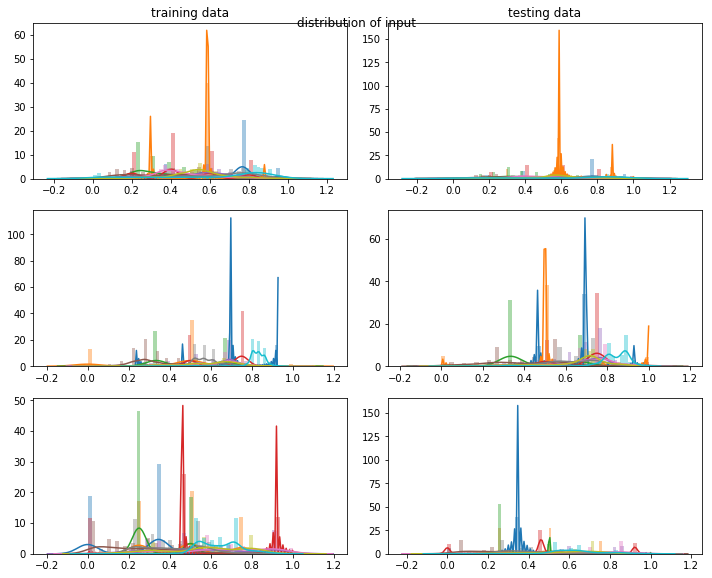

In [19]:
if _USE_TIME_SERIES_:
    plots.plot_2d_distribution(data_train[:,-1,:], data_test[:, -1, :])
else:
    plots.plot_2d_distribution(data_train, data_test);

## Use *tf.data* to create batches and shuffle the dataset

In [20]:
_TRAIN_BUFFER_SIZE_ = len(data_train) 

_TEST_BUFFER_SIZE_ = len(data_test) 

train_dataset = tf.data.Dataset.from_tensor_slices(data_train).shuffle(_TRAIN_BUFFER_SIZE_).batch(_BATCH_SIZE_)
test_dataset = tf.data.Dataset.from_tensor_slices(data_test).shuffle(_TEST_BUFFER_SIZE_).batch(_BATCH_SIZE_)

# model def

## doc

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

The dilated convolution between signal $f$ and kernel $k$ and dilution factor $l$ is defined as:

$$\left(k \ast_{l} f\right)_t = \sum_{\tau=-\infty}^{\infty} k_\tau \cdot f_{t - l\tau}$$

![](./figures/diluted_convolution.png)

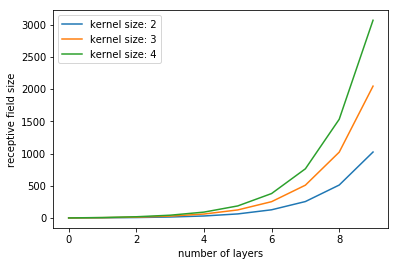

In [21]:
def _receptive_field_size_temporal_conv_net_(kernel_size, n_layers):
    return (1 + 2 * (kernel_size - 1) * (2 ** n_layers - 1))

for k in range(2, 5):
    plt.plot([_receptive_field_size_temporal_conv_net_(kernel_size=k, n_layers=n) for n in range(10)], label=f"kernel size: {k}")
plt.xlabel('number of layers')
plt.ylabel('receptive field size')
plt.legend()

## code

In [22]:
# Source: https://medium.com/the-artificial-impostor/notes-understanding-tensorflow-part-3-7f6633fcc7c7

class TemporalBlock(tfkl.Layer):
    def __init__(self, n_outputs, kernel_size, dilation_rate, dropout=0.2, trainable=True, name=None, dtype=None, activity_regularizer=None, **kwargs):
        """
        In the dilated convolution, the kernel only touches the signal at every lth entry 
        See https://www.inference.vc/dilated-convolutions-and-kronecker-factorisation/
        """
        super(TemporalBlock, self).__init__(
            trainable=trainable, dtype=dtype,
            activity_regularizer=activity_regularizer,
            name=name, **kwargs)        
        self.dropout = dropout
        self.n_outputs = n_outputs
        causal_conv_args = {"padding": "causal",
                            "dilation_rate": dilation_rate, 
                            "activation": tf.nn.relu}
        self.conv1 = tfkl.Conv1D(n_outputs, kernel_size, **causal_conv_args, name="conv1")
        self.conv2 = tfkl.Conv1D(n_outputs, kernel_size, **causal_conv_args, name="conv2")
        self.down_sample = None

    
    def build(self, input_shape):
        channel_dim = -1
        # from https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
        # noise_shape: 1D integer tensor representing the shape of the binary dropout mask that will be multiplied with the input. 
        # For instance, if your inputs have shape (batch_size, timesteps, features) and you want the dropout mask to be the same 
        # for all timesteps, you can use noise_shape=(batch_size, 1, features). 
        # SpatialDropout1D proved to be much better. Original paper: https://arxiv.org/abs/1411.4280
        self.dropout1 = tfkl.SpatialDropout1D(self.dropout)
        self.dropout2 = tfkl.SpatialDropout1D(self.dropout)
        if input_shape[channel_dim] != self.n_outputs:
            # TODO why not a conv1d layer?
            # self.down_sample = tf.layers.Conv1D(
            #     self.n_outputs, kernel_size=1, 
            #     activation=None, data_format="channels_last", padding="valid")
            self.down_sample = tf.layers.Dense(self.n_outputs, activation=None)
        self.built = True
    
    def call(self, inputs, training=True):
        x = self.conv1(inputs)
        x = tf.contrib.layers.layer_norm(x)
        x = self.dropout1(x, training=training)
        x = self.conv2(x)
        x = tf.contrib.layers.layer_norm(x)
        x = self.dropout2(x, training=training)
        if self.down_sample is not None:
            inputs = self.down_sample(inputs)
        return tf.nn.relu(x + inputs)

class TemporalConvNet(tf.layers.Layer):
    def __init__(self, num_channels, kernel_size=3, dropout=0.2,
                 trainable=True, name=None, dtype=None, 
                 activity_regularizer=None, **kwargs):
        super(TemporalConvNet, self).__init__(
            trainable=trainable, dtype=dtype,
            activity_regularizer=activity_regularizer,
            name=name, **kwargs
        )
        
        # TODO why not use a sequential layer here?
        self.layers = [TemporalBlock(n_out_channels, 
                                     kernel_size,
                                     dilation_rate=2 ** i,
                                     dropout=dropout,
                                     name=f"temporal_block_{i}") 
                       for i, n_out_channels in enumerate(num_channels)]
    
    def call(self, inputs, training=True):
        outputs = inputs
        for layer in self.layers:
            outputs = layer(outputs, training=training)
        return outputs

In [43]:
# build using:
#   - https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/contrib/eager/python/examples/generative_examples/cvae.ipynb 
#   - https://www.kaggle.com/hone5com/fraud-detection-with-variational-autoencoder

def if_last(ls):
    for i, x in enumerate(ls):
        yield i + 1 == len(ls), x

def dense_layers(sizes, name):
    return tfk.Sequential([tfkl.Dense(size, activation=None if is_last else tf.nn.leaky_relu)  
                         for is_last, size in if_last(sizes)], name=name)


class R_VAE(tf.keras.Model):
    def __init__(self, latent_dim, input_shape, batch_size, n_layers=3, dropout_rate_temporal=0.2):
        super(R_VAE, self).__init__()
        self.latent_dim = latent_dim
        self._input_shape = input_shape
        self._batch_size = batch_size
        self._layer_sizes_inference  = np.linspace(input_shape[-1], latent_dim, n_layers).astype(np.int)
        # pseudo reverse as the inference network goes down to, ask Semigh about this
        # the 2 * n_layers is to keep compression speed roughly the same
        self._layer_sizes_generative = np.linspace(latent_dim, input_shape[-1], n_layers).astype(np.int)
        
        self.inference_net = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=input_shape[-1]),
                                                 dense_layers(self._layer_sizes_inference, name='inference_net_dense_layers')],
                                                 name='inference_net')

        self.generative_net = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                                                  dense_layers(self._layer_sizes_generative, name='generative_net_dense_layers')],
                                                  name='generative_net')
        
        if len(input_shape) == 1:
            self.temporal_conv_net = None
        elif len(input_shape) == 2:
            self.temporal_conv_net = TemporalConvNet(num_channels=[input_shape[-1]] * 3,  
                                                     dropout=dropout_rate_temporal,
                                                     name='temporal_conv_net')
        else:
            raise ValueError(f"Input shape is not good, got: {input_shape}")
            
        print(self._config_())
    
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random_normal(shape=(self._batch_size, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
  
    def encode(self, x, training=False):
        if self.temporal_conv_net:
            # taking only the last entry
            x_tmp = tfkl.Lambda(lambda x: x[:, -1, :])(self.temporal_conv_net(x, training=training))
            return self.inference_net(x_tmp)
        else:
            return self.inference_net(x)
  
    def reparameterize(self, mean, logvar):
        eps = tf.random_normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
  
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
  
        return logits

    def predict(self, x):
        z = self.encode(x)
        return model.decode(z, apply_sigmoid=True)
    
    def _config_(self):
        return {
            "latent_dim": self.latent_dim,
            "input_shape": self._input_shape,
            "batch_size": self._batch_size,
            "layer_sizes_inference": self._layer_sizes_inference,
            "layer_sizes_generative": self._layer_sizes_generative,
        }

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [44]:
if _USE_TIME_SERIES_:
    assert len(data_train.shape) == 3, 'run all the necessary code, shape does not align with config'
else:
    assert len(data_train.shape) == 2, 'run all the necessary code, shape does not align with config'

In [45]:
data_test.shape

(459, 10, 30)

In [46]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x):
    z = model.encode(x)
    x_logit = model.decode(z)
    
    if len(x.shape) == 2:
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    else:
        # Note, the model is trained to reconstruct only the last, most current time step (by taking the last entry in the timeseries)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x[:, -1, :])
    #logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    
    # reconstruction loss
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1]) # down to [batch, loss]
    
    # KL loss
    #logpz = log_normal_pdf(z, 0., 0.)
    #logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z)

def compute_gradients(model, x): 
    with tf.GradientTape() as tape: 
        loss = compute_loss(model, x) 
        return tape.gradient(loss, model.trainable_variables), loss

optimizer = tf.train.AdamOptimizer(1e-4)
def apply_gradients(optimizer, gradients, variables, global_step=None):
    optimizer.apply_gradients(zip(gradients, variables), global_step=global_step)

## training

In [47]:
epochs = 10

if _DEBUG_ and _D_NO_COMPRESSION_:
    latent_dim=data_train.shape[-1]
else:
    latent_dim = 8

tf.reset_default_graph()
test_losses = []
train_losses = []

model = R_VAE(latent_dim, input_shape=data_train.shape[1:], batch_size=_BATCH_SIZE_, n_layers=4, dropout_rate_temporal=0.0)

model.inference_net.get_layer('inference_net_dense_layers').summary()
model.generative_net.get_layer('generative_net_dense_layers').summary()

{'latent_dim': 8, 'input_shape': (10, 30), 'batch_size': 100, 'layer_sizes_inference': array([30, 22, 15,  8]), 'layer_sizes_generative': array([ 8, 15, 22, 30])}
Model: "inference_net_dense_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dense_1 (Dense)              (None, 22)                682       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                345       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 128       
Total params: 2,085
Trainable params: 2,085
Non-trainable params: 0
_________________________________________________________________
Model: "generative_net_dense_layers"
____________________________________

In [48]:
print(f"will train model {model._config_()}, with global params: \n\t2d-data: {_USE_2D_DATA_}\n\ttime-series: {_USE_TIME_SERIES_}\n\tdebug-mode:{_DEBUG_}")
# TODO add tensorboard stuff
def _compute_loss_for_data_(model, data):
    loss = tfe.metrics.Mean()
    for x in data:
        loss(compute_loss(model, x))
    elbo = -loss.result()
    
    return elbo

#print(f"will train for {epochs} epochs")
#for epoch in range(1, epochs + 1):
print(f"will train for ever...")
epoch = len(train_losses)
while True:
    start_time = time.time()
    for train_x in train_dataset:
        gradients, loss = compute_gradients(model, train_x)
        apply_gradients(optimizer, gradients, model.trainable_variables)
    end_time = time.time()

    test_losses += [_compute_loss_for_data_(model, test_dataset)]
    train_losses += [_compute_loss_for_data_(model, train_dataset)]

    if epoch % 10 == 0:
        print(f"Epoch: {epoch:0>3}, train test loss: {test_losses[-1]:0.3f}, took {end_time - start_time:0.3f} sec")
        
    epoch += 1

will train model {'latent_dim': 8, 'input_shape': (10, 30), 'batch_size': 100, 'layer_sizes_inference': array([30, 22, 15,  8]), 'layer_sizes_generative': array([ 8, 15, 22, 30])}, with global params: 
	2d-data: True
	time-series: True
	debug-mode:False
will train for ever...
Epoch: 000, train test loss: -22.345, took 0.631 sec
Epoch: 010, train test loss: -20.802, took 0.566 sec
Epoch: 020, train test loss: -20.574, took 0.578 sec
Epoch: 030, train test loss: -20.347, took 0.491 sec
Epoch: 040, train test loss: -20.127, took 0.494 sec
Epoch: 050, train test loss: -19.974, took 0.558 sec
Epoch: 060, train test loss: -19.877, took 0.571 sec
Epoch: 070, train test loss: -19.796, took 0.584 sec
Epoch: 080, train test loss: -19.707, took 0.547 sec
Epoch: 090, train test loss: -19.615, took 0.559 sec
Epoch: 100, train test loss: -19.538, took 0.560 sec
Epoch: 110, train test loss: -19.496, took 0.548 sec
Epoch: 120, train test loss: -19.487, took 0.606 sec
Epoch: 130, train test loss: -19.4

Epoch: 1490, train test loss: -19.352, took 0.630 sec
Epoch: 1500, train test loss: -19.353, took 0.602 sec
Epoch: 1510, train test loss: -19.353, took 0.599 sec
Epoch: 1520, train test loss: -19.353, took 0.560 sec
Epoch: 1530, train test loss: -19.353, took 0.573 sec
Epoch: 1540, train test loss: -19.354, took 0.614 sec
Epoch: 1550, train test loss: -19.354, took 0.596 sec
Epoch: 1560, train test loss: -19.354, took 0.558 sec
Epoch: 1570, train test loss: -19.353, took 0.589 sec
Epoch: 1580, train test loss: -19.353, took 0.616 sec
Epoch: 1590, train test loss: -19.354, took 0.594 sec
Epoch: 1600, train test loss: -19.354, took 0.565 sec
Epoch: 1610, train test loss: -19.354, took 0.597 sec
Epoch: 1620, train test loss: -19.355, took 0.582 sec
Epoch: 1630, train test loss: -19.355, took 0.568 sec
Epoch: 1640, train test loss: -19.356, took 0.595 sec
Epoch: 1650, train test loss: -19.356, took 0.569 sec
Epoch: 1660, train test loss: -19.356, took 0.585 sec
Epoch: 1670, train test loss

Epoch: 3010, train test loss: -19.407, took 0.572 sec
Epoch: 3020, train test loss: -19.406, took 0.556 sec
Epoch: 3030, train test loss: -19.408, took 0.578 sec
Epoch: 3040, train test loss: -19.408, took 0.590 sec
Epoch: 3050, train test loss: -19.410, took 0.645 sec
Epoch: 3060, train test loss: -19.408, took 0.587 sec
Epoch: 3070, train test loss: -19.411, took 0.580 sec
Epoch: 3080, train test loss: -19.410, took 0.632 sec
Epoch: 3090, train test loss: -19.411, took 0.616 sec
Epoch: 3100, train test loss: -19.410, took 0.573 sec
Epoch: 3110, train test loss: -19.411, took 0.556 sec
Epoch: 3120, train test loss: -19.413, took 0.599 sec
Epoch: 3130, train test loss: -19.414, took 0.583 sec
Epoch: 3140, train test loss: -19.414, took 0.556 sec
Epoch: 3150, train test loss: -19.413, took 0.584 sec
Epoch: 3160, train test loss: -19.415, took 0.552 sec
Epoch: 3170, train test loss: -19.415, took 0.565 sec
Epoch: 3180, train test loss: -19.416, took 0.580 sec
Epoch: 3190, train test loss

SystemError: <built-in function TF_NewBuffer> returned a result with an error set

In [49]:
len(train_losses)

4240

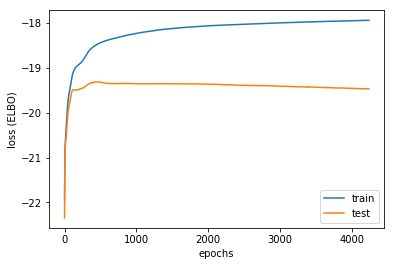

In [50]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epochs')
plt.ylabel('loss (ELBO)')
plt.legend()

In [51]:
def _reverse_to_original_shape_(pos_data, input_shape=None):
    input_shape = (15, -1)
        
    return scaler.inverse_transform(pos_data).reshape(pos_data.shape[0], *(input_shape))

In [59]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [62]:
eps = tf.random_normal(shape=(model._batch_size * 11, model.latent_dim))
gen_pos_data = _reverse_to_original_shape_(np.vstack([model.decode(eps_chunk, apply_sigmoid=True).numpy() for eps_chunk in chunks(eps, model._batch_size)]))

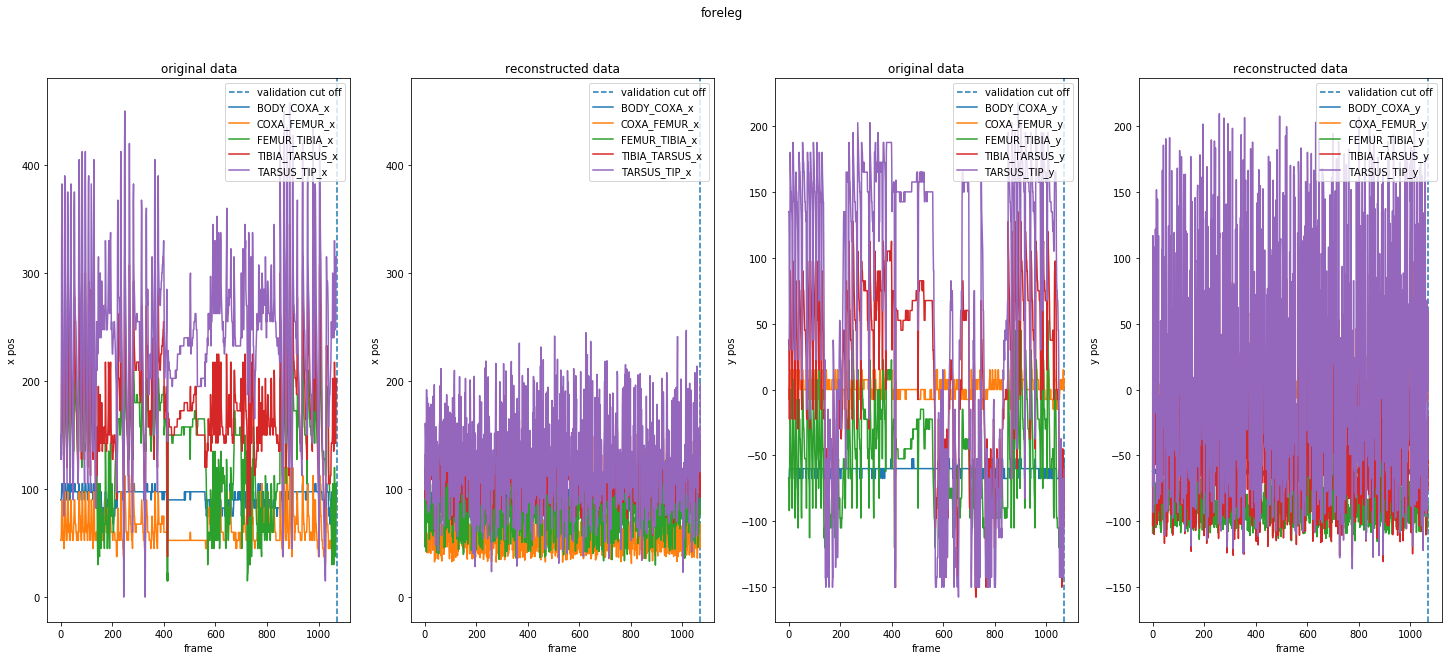

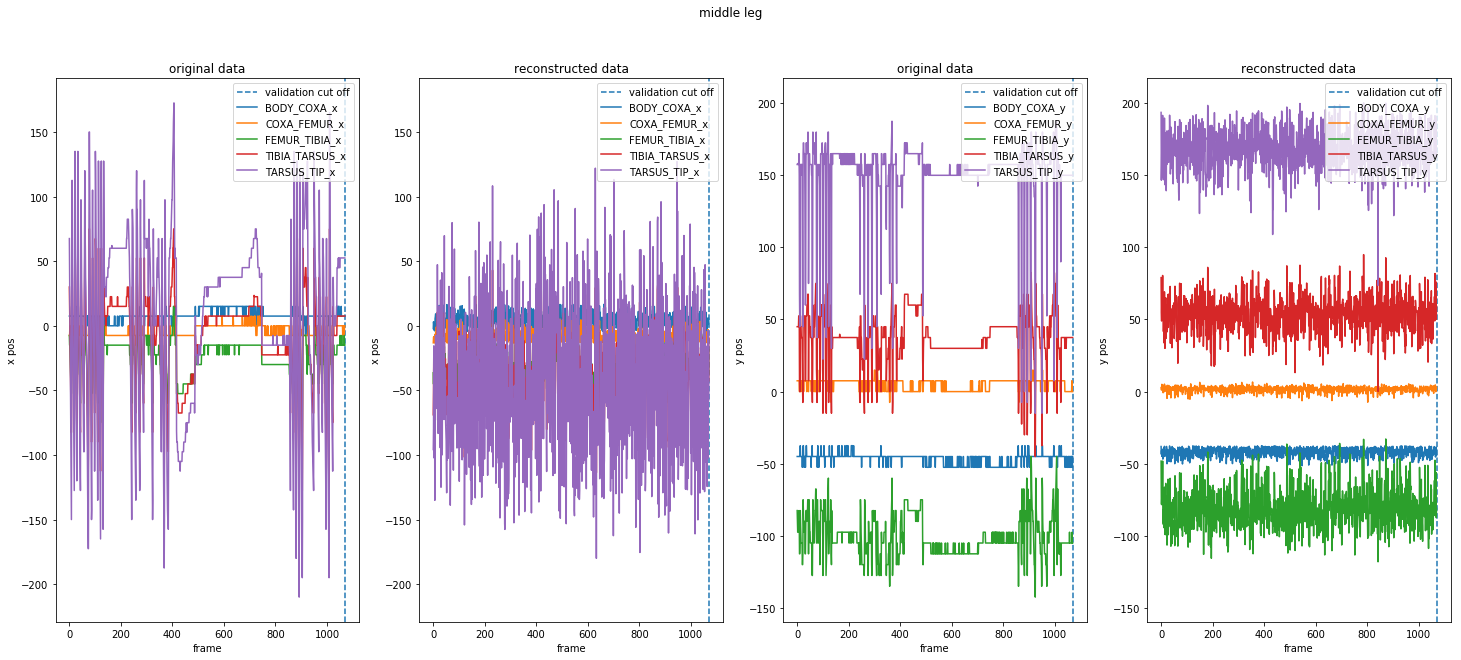

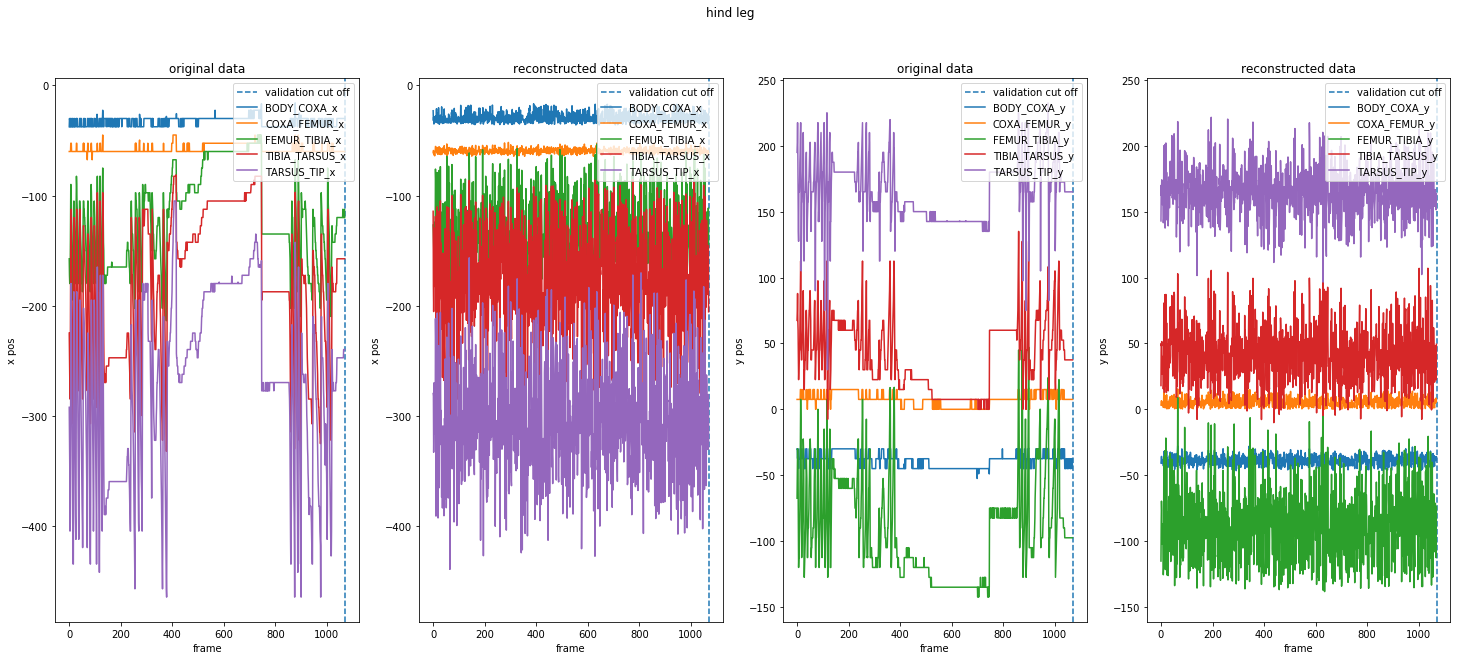

In [64]:
gen_pos_data = _reverse_to_original_shape_(np.vstack([model.sample().numpy() for _ in range(11)]))

if _USE_TIME_SERIES_: 
    plots.plot_comparing_joint_position_with_reconstructed(_reverse_to_original_shape_(data_train[:, -1, :]), 
                                                           gen_pos_data[:data_train.shape[0]],
                                                           validation_cut_off=data_train.shape[0])
else:
    plots.plot_comparing_joint_position_with_reconstructed(_reverse_to_original_shape_(data_train), 
                                                           gen_pos_data[:data_train.shape[0]],
                                                           validation_cut_off=data_train.shape[0])

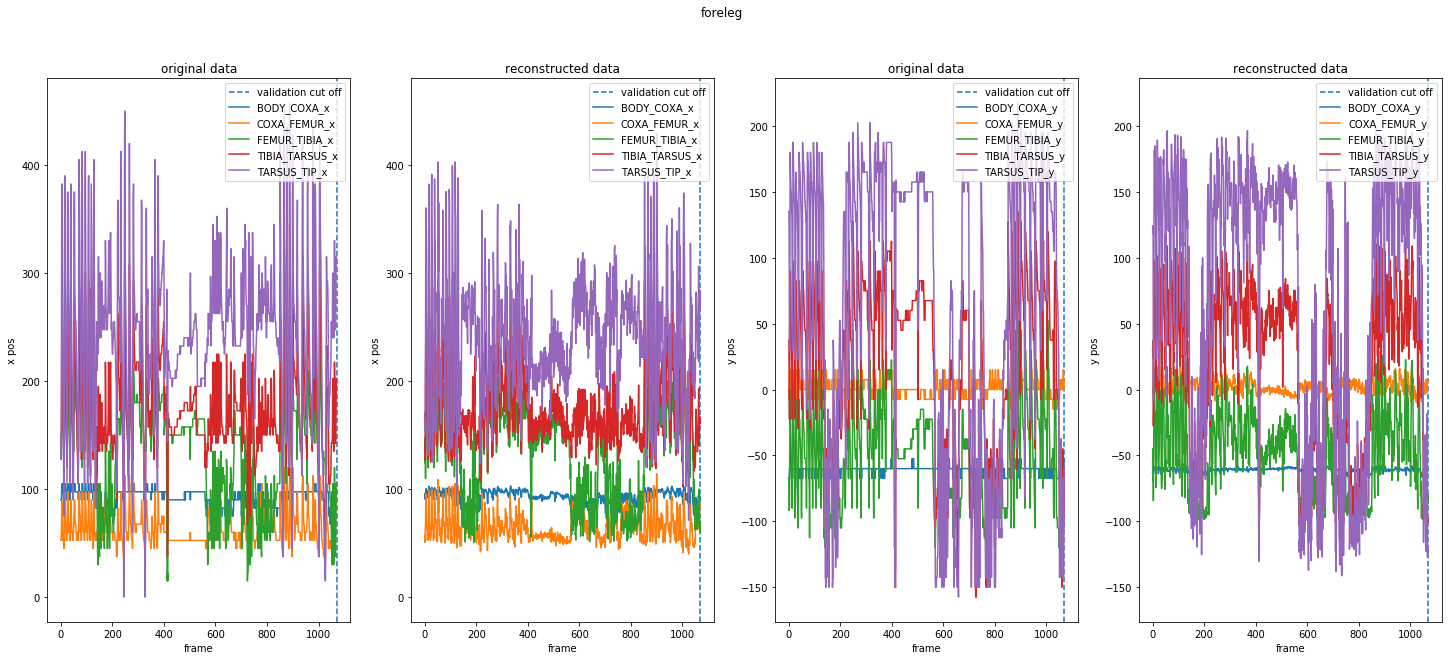

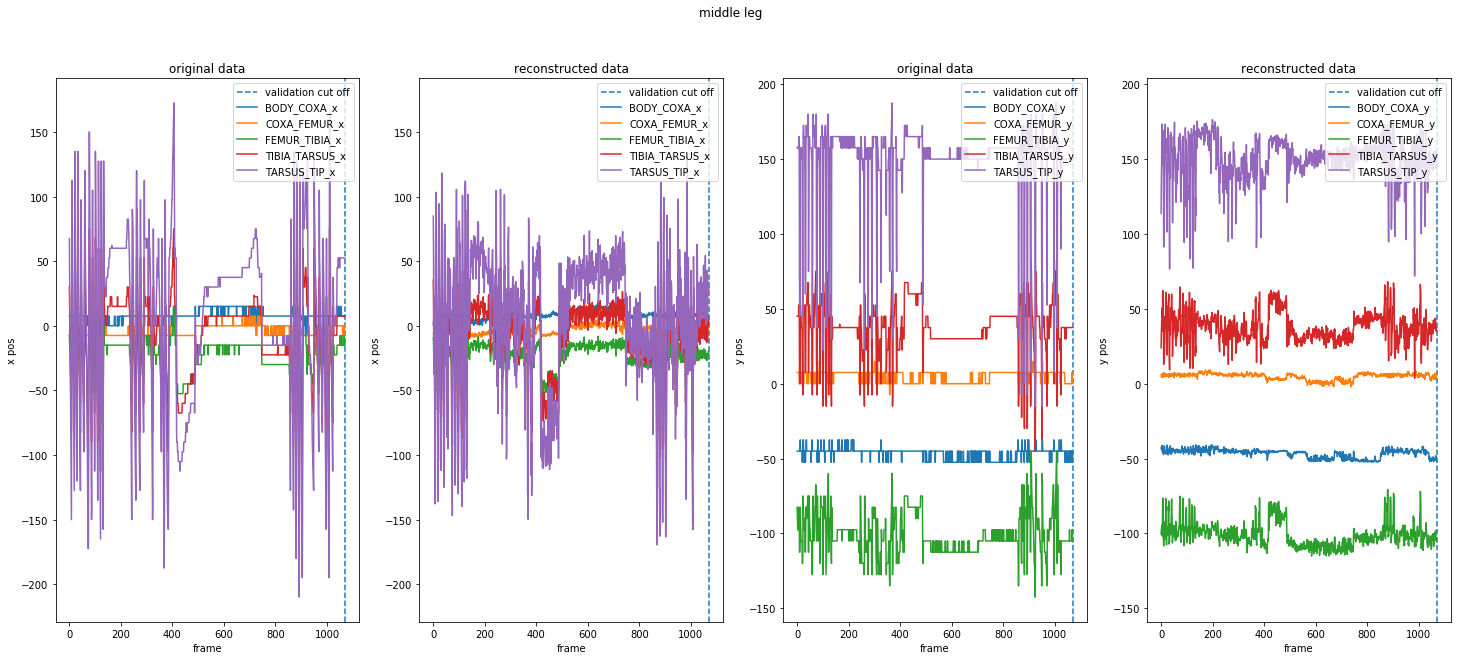

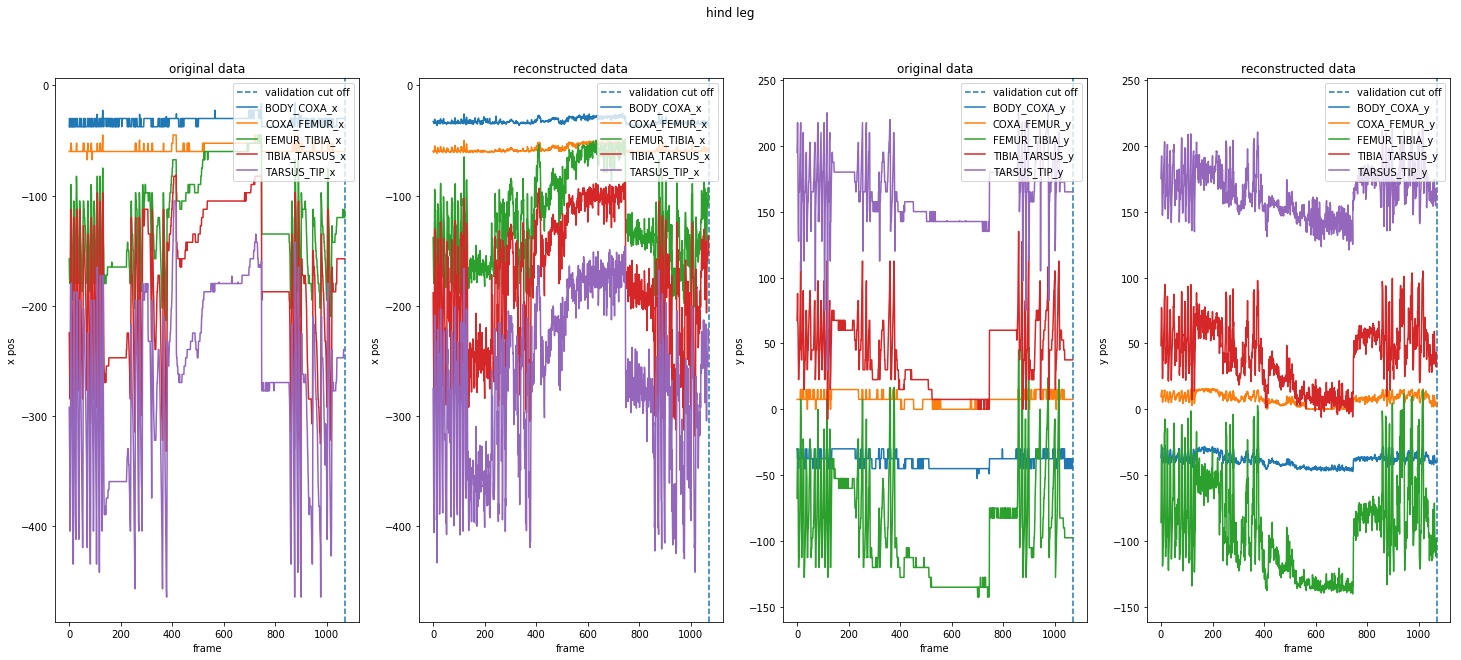

In [53]:
pred_train = model.predict(data_train).numpy()
pred_train_rev = _reverse_to_original_shape_(model.predict(data_train).numpy())

if _USE_TIME_SERIES_: 
    plots.plot_comparing_joint_position_with_reconstructed(_reverse_to_original_shape_(data_train[:, -1, :]),
                                                           pred_train_rev,
                                                           validation_cut_off=data_train.shape[0])
else:
    plots.plot_comparing_joint_position_with_reconstructed(_reverse_to_original_shape_(data_train), 
                                                           pred_train_rev,
                                                           validation_cut_off=data_train.shape[0])

In [66]:
model.encode(data_train).numpy()

array([[ 0.28342375,  1.8883085 ,  1.8825555 , ..., -0.8624275 ,
        -4.896894  , -4.3617983 ],
       [-0.29682878,  1.9644072 ,  2.1444862 , ..., -0.63086575,
        -4.2483625 , -4.4956656 ],
       [-1.3534312 ,  1.5048636 ,  2.2701051 , ..., -1.1548861 ,
        -3.8093114 , -3.989734  ],
       ...,
       [ 0.81320226,  5.020914  ,  1.7741987 , ...,  1.4209805 ,
        -3.42484   , -4.838137  ],
       [ 0.6231537 ,  4.020672  ,  1.367428  , ...,  1.0396203 ,
        -2.6448464 , -4.2251434 ],
       [ 0.7779168 ,  5.219575  ,  2.0111818 , ...,  1.151384  ,
        -3.2204688 , -5.2974696 ]], dtype=float32)

In [71]:
from sklearn.manifold import TSNE


x_hat_latent = model.encode(np.concatenate((data_train, data_test))).numpy()

X_embedded = TSNE(n_components=2, random_state=42).fit_transform(x_hat_latent)

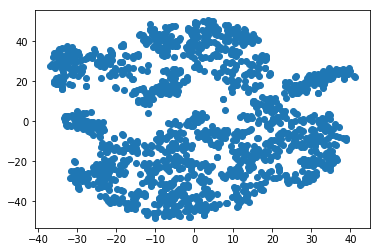

In [75]:
plt.scatter(X_embedded[:,0], X_embedded[:,1])

In [77]:
training_frames = frames_idx_with_labels[frames_of_interest][:data_train.shape[0]]
testing_frames = frames_idx_with_labels[frames_of_interest][data_train.shape[0]:]
    
seen_labels = training_frames.label.unique()

_cs = sns.color_palette(n_colors=len(seen_labels))

fig = plt.figure(figsize=(10, 10))
_all_frames_ = pd.concat((training_frames, testing_frames))

behaviour_colours = dict(zip(seen_labels, _cs))

for l, c in behaviour_colours.items():
    _d = X_embedded[_all_frames_['label'] == l]
    # c=[c] since matplotlib asks for it
    plt.scatter(_d[:, 0], _d[:,1], c=[c], label=l.name, marker='.')
    
plt.legend()
plt.title('simple t-SNE on latent space')
#fig.savefig(f"../neural_clustering_data/figures/{drosoph_vae_config['ex_name']}_tsne.png")

/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1529 but corresponding boolean dimension is 1538

<Figure size 720x720 with 0 Axes>

In [72]:
if drosoph_vae_config['time_series']:
    _time_series_last_frame_idx_ = [idx[-1] for idx in _time_series_idx_]

    training_frames = frames_idx_with_labels[frames_of_interest].iloc[_time_series_last_frame_idx_][:x_hat_latent_train.shape[0]]
    testing_frames = frames_idx_with_labels[frames_of_interest].iloc[_time_series_last_frame_idx_][x_hat_latent_train.shape[0]:]
else:
    training_frames = frames_idx_with_labels[frames_of_interest][:x_hat_latent_train.shape[0]]
    testing_frames = frames_idx_with_labels[frames_of_interest][x_hat_latent_train.shape[0]:]
    
seen_labels = training_frames.label.unique()

_cs = sns.color_palette(n_colors=len(seen_labels))

fig = plt.figure(figsize=(10, 10))
_all_frames_ = pd.concat((training_frames, testing_frames))

behaviour_colours = dict(zip(seen_labels, _cs))

for l, c in behaviour_colours.items():
    _d = X_embedded[_all_frames_['label'] == l]
    # c=[c] since matplotlib asks for it
    plt.scatter(_d[:, 0], _d[:,1], c=[c], label=l.name, marker='.')
    
plt.legend()
plt.title('simple t-SNE on latent space')
#fig.savefig(f"../neural_clustering_data/figures/{drosoph_vae_config['ex_name']}_tsne.png")

,frame_id_in_experiment,label
0,0,_BehaviorLabel_.WALK_FORW
1,1,_BehaviorLabel_.WALK_FORW
2,2,_BehaviorLabel_.WALK_FORW
3,3,_BehaviorLabel_.WALK_FORW
4,4,_BehaviorLabel_.WALK_FORW
5,5,_BehaviorLabel_.WALK_FORW
6,6,_BehaviorLabel_.WALK_FORW
7,7,_BehaviorLabel_.WALK_FORW
8,8,_BehaviorLabel_.WALK_FORW
9,9,_BehaviorLabel_.WALK_FORW


In [54]:
stop
reload(plots)
if config.NB_DIMS == 3:
    if drosoph_vae_config['time_series']:
        _time_series_idx_ = [t[-1] for t in to_time_series(range(len(joint_positions)))]
        timed_jp = joint_positions[_time_series_idx_]
    else:
        timed_jp = joint_positions
        
    f = plots.plot_reconstructed_angle_data(real_data=timed_jp,
                                            reconstructed_data=np.vstack((reconstructed_from_encoding_train, reconstructed_from_encoding_val)), 
                                            columns=angled_data_columns)
    p = f"../neural_clustering_data/figures/{drosoph_vae_config['ex_name']}_angled_plot_.png"
    pathlib.Path(p).parent.mkdir(exist_ok=True)
    f.savefig(p)
else:
    if drosoph_vae_config['time_series']:
        _time_series_idx_ = [t[-1] for t in to_time_series(range(len(joint_positions)))]
        timed_jp = joint_positions[_time_series_idx_]

        plots.plot_comparing_joint_position_with_reconstructed(timed_jp, 
                                                               np.vstack((reconstructed_from_encoding_train, reconstructed_from_encoding_val)), 
                                                               validation_cut_off=nb_of_data_points)
    else:
        plots.plot_comparing_joint_position_with_reconstructed(joint_positions, 
                                                               np.vstack((reconstructed_from_encoding_train, reconstructed_from_encoding_val)), 
                                                               validation_cut_off=nb_of_data_points)

        plots.plot_comparing_joint_position_with_reconstructed(joint_positions, 
                                                               np.vstack((reconstructed_from_embedding_train, reconstructed_from_embedding_val)), 
                                                               validation_cut_off=nb_of_data_points)

NameError: name 'stop' is not defined

# Graveyard

In [ ]:
#class TemporalBlock(tf.keras.Model):
#    def __init__(self, dilation_rate, nb_filters, kernel_size, padding, dropout_rate=0.0): 
#        super(TemporalBlock, self).__init__()
#        # TODO check if this is correct
#        init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
#        assert padding in ['causal', 'same']
#
#        # block1
#        self.conv1  = tfkl.Conv1D(filters=nb_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, kernel_initializer=init)
#        self.batch1 = tfkl.BatchNormalization(axis=-1)
#        self.ac1    = tfkl.Activation('relu')
#        self.drop1  = tfkl.Dropout(rate=dropout_rate)
#        
#        # block2
#        self.conv2  = tfkl.Conv1D(filters=nb_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, kernel_initializer=init)
#        self.batch2 = tfkl.BatchNormalization(axis=-1)        
#        self.ac2    = tfkl.Activation('relu')
#        self.drop2  = tfkl.Dropout(rate=dropout_rate)
#
#        self.downsample = tfkl.Conv1D(filters=nb_filters, kernel_size=1, padding='same', kernel_initializer=init)
#        self.ac3    = tfkl.Activation('relu')
#
#
#    def call(self, x, training):
#        prev_x = x
#        x = self.conv1(x)
#        x = self.batch1(x)
#        x = self.ac1(x)
#        x = self.drop1(x) if training else x
#
#        x = self.conv2(x)
#        x = self.batch2(x)
#        x = self.ac2(x)
#        x = self.drop2(x) if training else x
#
#        if prev_x.shape[-1] != x.shape[-1]:    # match the dimention
#            prev_x = self.downsample(prev_x)
#        assert prev_x.shape == x.shape
#
#        return self.ac3(prev_x + x)            # skip connection
#
#
#
#class TemporalConvNet(tf.keras.Model):
#    def __init__(self, num_channels, kernel_size=2, dropout=0.2):
#        # num_channels is a list contains hidden sizes of Conv1D
#        super(TemporalConvNet, self).__init__()
#        assert isinstance(num_channels, list)
#
#        model = tf.keras.Sequential()
#
#        # The model contains "num_levels" TemporalBlock
#        num_levels = len(num_channels)
#        for i in range(num_levels):
#            dilation_rate = 2 ** i                  # exponential growth
#            model.add(TemporalBlock(dilation_rate=dilation_rate, nb_filters=num_channels[i], kernel_size=kernel_size, padding='causal', dropout_rate=dropout))
#        self.network = model
#
#    def call(self, x, training):
#        return self.network(x, training=training)

# V3
from typing import List, Tuple

import keras.backend as K
import keras.layers
from keras import optimizers
from keras.engine.topology import Layer
from keras.layers import Activation, Lambda
from keras.layers import Conv1D, SpatialDropout1D
from keras.layers import Convolution1D, Dense
from keras.models import Input, Model


def residual_block(x, dilation_rate, nb_filters, kernel_size, padding, dropout_rate=0):
    # type: (Layer, int, int, int, str, float) -> Tuple[Layer, Layer]
    """Defines the residual block for the WaveNet TCN

    Args:
        x: The previous layer in the model
        dilation_rate: The dilation power of 2 we are using for this residual block
        nb_filters: The number of convolutional filters to use in this block
        kernel_size: The size of the convolutional kernel
        padding: The padding used in the convolutional layers, 'same' or 'causal'.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.

    Returns:
        A tuple where the first element is the residual model layer, and the second
        is the skip connection.
    """
    prev_x = x
    for k in range(2):
        x = Conv1D(filters=nb_filters,
                   kernel_size=kernel_size,
                   dilation_rate=dilation_rate,
                   padding=padding)(x)
        # x = BatchNormalization()(x)  # TODO should be WeightNorm here.
        x = Activation('relu')(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)

    # 1x1 conv to match the shapes (channel dimension).
    prev_x = Conv1D(nb_filters, 1, padding='same')(prev_x)
    res_x = keras.layers.add([prev_x, x])
    return res_x, x


def process_dilations(dilations):
    def is_power_of_two(num):
        return num != 0 and ((num & (num - 1)) == 0)

    if all([is_power_of_two(i) for i in dilations]):
        return dilations

    else:
        new_dilations = [2 ** i for i in dilations]
        # print(f'Updated dilations from {dilations} to {new_dilations} because of backwards compatibility.')
        return new_dilations


class TCN(tf.layers.Layer):
    """Creates a TCN layer.

        Input shape:
            A tensor of shape (batch_size, timesteps, input_dim).

        Args:
            nb_filters: The number of filters to use in the convolutional layers.
            kernel_size: The size of the kernel to use in each convolutional layer.
            dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
            nb_stacks : The number of stacks of residual blocks to use.
            padding: The padding to use in the convolutional layers, 'causal' or 'same'.
            use_skip_connections: Boolean. If we want to add skip connections from input to each residual block.
            return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            name: Name of the model. Useful when having multiple TCN.

        Returns:
            A TCN layer.
        """

    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=[1, 2, 4, 8, 16, 32],
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=False,
                 name='tcn'):
        self.name = name
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.padding = padding

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")


    def __call__(self, inputs):
        x = inputs
        # 1D FCN.
        x = Convolution1D(self.nb_filters, 1, padding=self.padding)(x)
        skip_connections = []
        for s in range(self.nb_stacks):
            for d in self.dilations:
                x, skip_out = residual_block(x,
                                             dilation_rate=d,
                                             nb_filters=self.nb_filters,
                                             kernel_size=self.kernel_size,
                                             padding=self.padding,
                                             dropout_rate=self.dropout_rate)
                skip_connections.append(skip_out)
        if self.use_skip_connections:
            x = keras.layers.add(skip_connections)
        if not self.return_sequences:
            x = Lambda(lambda tt: tt[:, -1, :])(x)
        return x